In [19]:
# from datetime import timedelta
import cv2
import numpy as np
import os
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from icecream import ic

import torch
import torchvision.transforms as transforms

## some util
def print_img_stats(*imgs):
    for img in imgs:
        print(img.shape, img.min(), img.max())
        
def load_uint8_img(img_path):
    """load img as uint8"""
    img = plt.imread(img_path)
    if img.max() < 100: # float
        img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    else:
        img = np.clip(img, 0, 255).astype(np.uint8)
    return img

# Find bbox alignment of `objectBounds`

In [23]:
img_path = "data/calibration/image.jpg"
img = load_uint8_img(img_path)[:,::-1].copy()
print_img_stats(img)

(640, 480, 3) 0 250


In [24]:
x1,y1,w,h = 147.59439945220947, 35.97414493560791,166.49130821228027,159.84950065612793

x1,y1,w,h = y1,x1,h,w

# x2,y2 = x1+w, y1+h
# x1,y1 = 480-y2, 480-x2

x1,y1, w,h = int(x1), int(y1), int(w), int(h)
x2,y2 = x1+w, y1+h


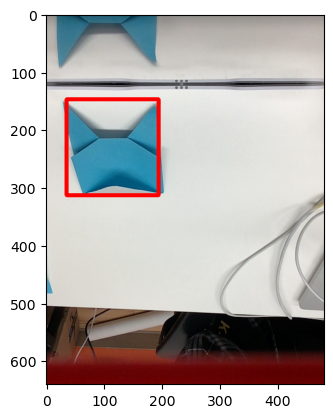

In [25]:
cv2.rectangle(img, (x1,y1), (x2,y2), color=[255,0,0], thickness=5)
plt.imshow(img)

# Homography

The current transform based on exif will horizontally flip the img

In [26]:
img_path = "data/calibration/homo_img.jpg"
img = load_uint8_img(img_path)[:,::-1].copy()
print_img_stats(img)

(640, 480, 3) 0 255


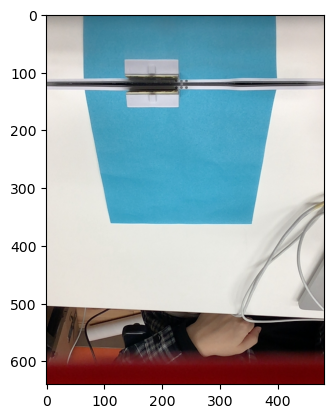

In [30]:
plt.imshow(img)
plt.show()

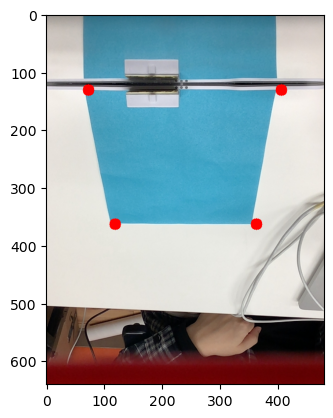

In [48]:
offset = int(480/2 - (398+65)/2) # to assume that the square captured was in the middle
points = [
    [65,131],
    [398,131],
    [355,363],
    [111,363]
]
for pt in points:
    pt[0] += offset
img_anno = img.copy()
for (x,y) in points:
    cv2.circle(img_anno, (x,y), 10, (255,0,0), thickness=-1)
plt.imshow(img_anno)
plt.show()

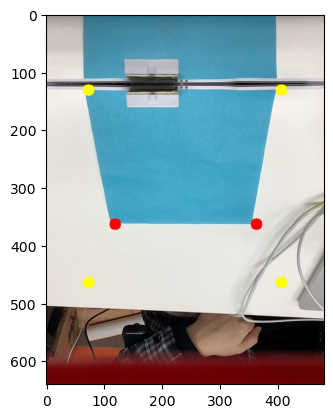

In [49]:
size = points[1][0] - points[0][0]
target_points = [
    points[0],
    points[1],
    [points[0][0]+size, points[0][1]+size],
    [points[0][0], points[0][1]+size],
]
img_anno2 = img_anno.copy()
for (x,y) in target_points:
    cv2.circle(img_anno2, (x,y), 10, (255,255,0), thickness=-1)
plt.imshow(img_anno2)
plt.show()

In [50]:
(target_points[1][0] + target_points[0][0])/2

239.5

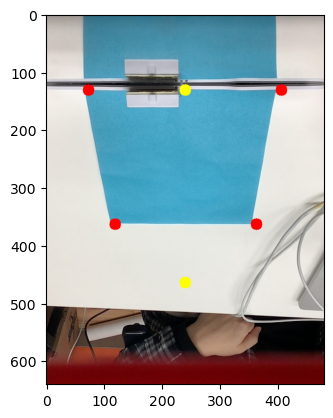

In [51]:
## to fix target to start from the middle of the osmo as the origin
osmo_x = 240
osmo_y = 131
osmo_target_points = [
    [osmo_x, osmo_y],
    [osmo_x+size, osmo_y],
    [osmo_x+size, osmo_y+size],
    [osmo_x, osmo_y+size]
]
img_anno3 = img_anno.copy()
for (x,y) in osmo_target_points:
    cv2.circle(img_anno3, (x,y), 10, (255,255,0), thickness=-1)
plt.imshow(img_anno3)
plt.show()

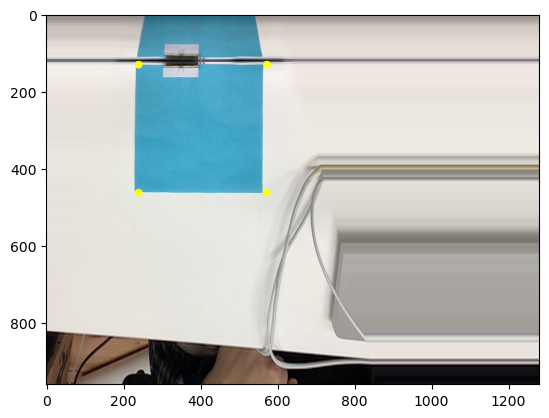

In [56]:
M, mask = cv2.findHomography(np.array(points).astype(np.float32), 
                             np.array(osmo_target_points).astype(np.float32))
new_shape = (640*2, 480*2)
warp_img = cv2.warpPerspective(img, M, new_shape, 
                               flags=cv2.INTER_LANCZOS4,
                               borderMode = cv2.BORDER_REPLICATE)
homo_points = np.concatenate([np.array(points), np.ones((4,1))], axis=1)
pred_points = homo_points @ M.T
pred_points = pred_points[:,:2] / pred_points[:,2:]
pred_points = pred_points.astype(int)
for (x,y) in pred_points:
    cv2.circle(warp_img, (x,y), 10, (255,255,0), thickness=-1)
plt.imshow(warp_img)
plt.show()

In [57]:
pred_points[0]

array([240, 131])

In [58]:
M

array([[ 8.68874768e-01, -4.12506326e-01,  1.99140415e+02],
       [-6.04019931e-16,  7.82691334e-01,  1.12900298e+01],
       [-1.84209407e-18, -1.00095597e-03,  1.00000000e+00]])

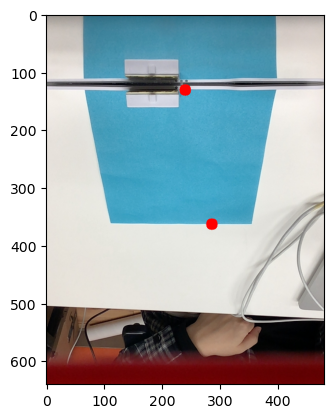

In [63]:
## move so that the upper left point is at the osmo middle
offset = int(480/2 - 65) # to assume that the square captured was in the middle
points = [
    [65,131],
    [398,131],
    [355,363],
    [111,363]
]
for pt in points:
    pt[0] += offset
img_anno = img.copy()
for (x,y) in points:
    cv2.circle(img_anno, (x,y), 10, (255,0,0), thickness=-1)
plt.imshow(img_anno)
plt.show()

In [64]:
## to fix target to start from the middle of the osmo as the origin, table mm coord
osmo_x = 0
osmo_y = 0
real_size = 150
osmo_mm_target_points = [
    [osmo_x, osmo_y],
    [osmo_x+real_size, osmo_y],
    [osmo_x+real_size, osmo_y+real_size],
    [osmo_x, osmo_y+real_size]
]
osmo_mm_target_points

[[0, 0], [150, 0], [150, 150], [0, 150]]

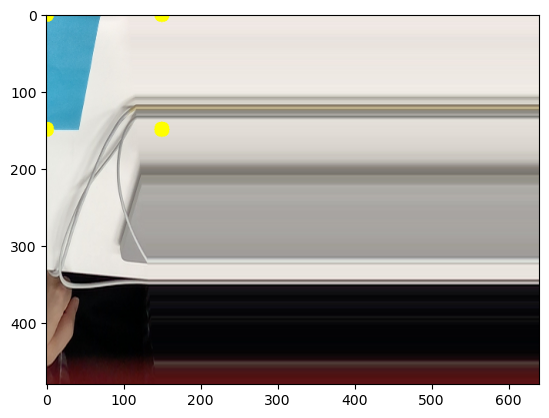

In [65]:
M, mask = cv2.findHomography(np.array(points).astype(np.float32), 
                             np.array(osmo_mm_target_points).astype(np.float32))
new_shape = (640, 480)
warp_img = cv2.warpPerspective(img, M, new_shape, 
                               flags=cv2.INTER_LANCZOS4,
                               borderMode = cv2.BORDER_REPLICATE)
homo_points = np.concatenate([np.array(points), np.ones((4,1))], axis=1)
pred_points = homo_points @ M.T
pred_points = pred_points[:,:2] / pred_points[:,2:]
pred_points = pred_points.astype(int)
for (x,y) in pred_points:
    cv2.circle(warp_img, (x,y), 10, (255,255,0), thickness=-1)
plt.imshow(warp_img)
plt.show()

In [66]:
M

array([[ 3.91385031e-01, -7.76022044e-02, -8.37665186e+01],
       [-1.63380904e-16,  4.11629084e-01, -5.39234100e+01],
       [-1.84209407e-18, -1.00095597e-03,  1.00000000e+00]])

(640, 480, 3) 0 255


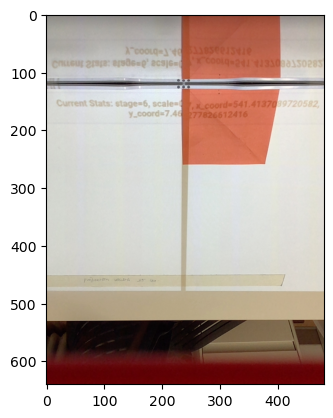

In [67]:
img_path = "data/calibration/homo_img2.jpg"
img = load_uint8_img(img_path)[:,::-1].copy()
print_img_stats(img)
plt.imshow(img)
plt.show()

[[240, 129], [408, 129], [384, 260], [240, 260]]


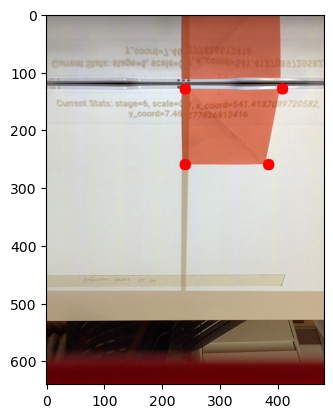

In [73]:
points = [
    [235,129],
    [403,129],
    [379,260],
    [235,260],
]
offset = int(480/2 - points[0][0]) # to assume that the square captured was in the middle
for pt in points:
    pt[0] += offset
print(points)
img_anno = img.copy()
for (x,y) in points:
    cv2.circle(img_anno, (x,y), 10, (255,0,0), thickness=-1)
plt.imshow(img_anno)
plt.show()

In [74]:
## to fix target to start from the middle of the osmo as the origin, table mm coord
osmo_x = 0
osmo_y = 0
real_size = 7.75*10
osmo_mm_target_points = [
    [osmo_x, osmo_y],
    [osmo_x+real_size, osmo_y],
    [osmo_x+real_size, osmo_y+real_size],
    [osmo_x, osmo_y+real_size]
]
osmo_mm_target_points

[[0, 0], [77.5, 0], [77.5, 77.5], [0, 77.5]]

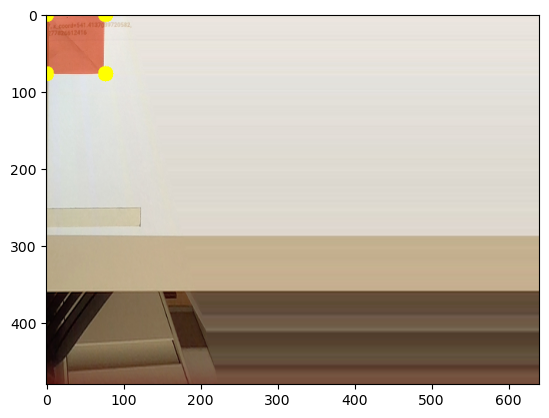

In [75]:
M, mask = cv2.findHomography(np.array(points).astype(np.float32), 
                             np.array(osmo_mm_target_points).astype(np.float32))
new_shape = (640, 480)
warp_img = cv2.warpPerspective(img, M, new_shape, 
                               flags=cv2.INTER_LANCZOS4,
                               borderMode = cv2.BORDER_REPLICATE)
homo_points = np.concatenate([np.array(points), np.ones((4,1))], axis=1)
pred_points = homo_points @ M.T
pred_points = pred_points[:,:2] / pred_points[:,2:]
pred_points = pred_points.astype(int)
for (x,y) in pred_points:
    cv2.circle(warp_img, (x,y), 10, (255,255,0), thickness=-1)
plt.imshow(warp_img)
plt.show()

In [76]:
M

array([[ 4.04417623e-01, -1.00672980e-16, -9.70602294e+01],
       [-4.17131426e-17,  4.44550669e-01, -5.73470363e+01],
       [-2.35018606e-18, -9.56022945e-04,  1.00000000e+00]])